In [1]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img

%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img
from torch.utils.data import DataLoader, Dataset

%load_ext autoreload
%autoreload 2

class DatasetSplit(Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = list(idxs)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, label

class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 15  # "number of users: N"
    num_partition = 6 # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep = 1 #"the number of local epochs: E"
    local_bs = 200 #"local batch size: B"
    bs=200 #"test batch size"
    lr=0.01 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='None' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

# load dataset and split users
trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)

dict_users = mnist_iid(dataset_train, args.num_partition)

encoding_input_array_np = np.empty((len(dataset_train),28*28))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(60000/args.num_partition)

for i in range(args.num_partition):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,28*28))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np


# print(labels_np[0:10,:])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
size of X: (60000, 784)
size of Y: (60000, 10)


# 1.1. Encoding MNIST (N=15, K=6, T=3, Sigma=0.1)

In [4]:
from utils.functions import *
import math

N = args.num_users
K = args.num_partition
T = 3
sigma = 0.01
Noise_Alloc = [2,4,7] # np.random.choice(range(K+T), T, replace=False)


j_array = np.array(range(K+T))
# print("j: ",(2*j_array+1)*math.pi/2/K,'\n')

alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
print("alpha_array: ",alpha_array,'\n')

i_array = np.array(range(N))
z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
print("z_array: ",z_array,'\n')

Noise_Alloc = [2,4,6]
X_tilde,a,b = BACC_Enc_withNoise(encoding_input_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
y_tilde,a,b = BACC_Enc_withNoise(encoding_label_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

print(X_tilde.shape)

alpha_array:  [ 9.84807753e-01  8.66025404e-01  6.42787610e-01  3.42020143e-01
  6.12323400e-17 -3.42020143e-01 -6.42787610e-01 -8.66025404e-01
 -9.84807753e-01] 

z_array:  [ 1.          0.9781476   0.91354546  0.80901699  0.66913061  0.5
  0.30901699  0.10452846 -0.10452846 -0.30901699 -0.5        -0.66913061
 -0.80901699 -0.91354546 -0.9781476 ] 

@BACC_Enc: N,K,T, m_i= 15 6 3 10000 

@BACC_Enc: N,K,T, m_i= 15 6 3 10000 

(15, 10000, 784)


In [15]:
Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)
print(Signal_Alloc)

[0, 1, 3, 5, 7, 8]


In [16]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

# training
loss_train_arr = []
loss_test_arr = []
acc_test_arr = []
net_best = None
best_loss = None

N_trials = 1
N_epochs = 30

# m_array = np.array(range(4,16)) # m is the number of received result @ master
m_array = np.array([15]) # m is the number of received result @ master
loss_test_arr = np.empty((len(m_array),N_trials,N_epochs))
acc_test_arr  = np.empty((len(m_array),N_trials,N_epochs))

for m_idx in range(len(m_array)):   
    
    m = m_array[m_idx] # m is the number of received result @ master
    print('number of results:',m)
    
    for trial_idx in range(N_trials):
        print('(m=',m,') ',trial_idx,'-th Trial!!')
        
        net_glob = CNNMnist2(args=args)
        net_glob.cuda()
        net_glob.train()

        # copy weights
        w_glob = net_glob.state_dict()
        
        y_hat = net_glob(X_tilde[idx,:,:])
        for iter in range(N_epochs): #args.epochs
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)

            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

            # copy weight to net_glob
            net_glob.load_state_dict(w_glob)

            # print loss
        #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

        #     loss_train_arr.append(loss_train)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test_arr[m_idx][trial_idx][iter] = acc_test
            loss_test_arr[m_idx][trial_idx][iter] = loss_test
            if iter % 1 ==0:
                print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
            #print(loss_train)

number of results: 15
(m= 15 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.2995 
Accuracy: 1171/10000 (11.71%)

Round   0, Average loss 2.299 Test accuracy 11.710
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.5675 
Accuracy: 7552/10000 (75.52%)

Round   1, Average loss 1.568 Test accuracy 75.520
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 4.0586 
Accuracy: 7524/10000 (75.24%)

Round   2, Average loss 4.059 Test accuracy 75.240
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 6.1901 
Accuracy: 7005/10000 (70.05%)

Round   3, Average loss 6.190 Test accuracy 70.050
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 5.1861 
Accuracy: 7385/10000 (73.85%)

Round   4, Average loss 5.186 Test accuracy 73.850
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]



In [12]:
print(alpha_array[Signal_Alloc])

[ 0.98480775  0.8660254   0.34202014 -0.34202014 -0.8660254  -0.98480775]


# 1.1. Encoding MNIST (N=15, K=6, T=[0,1,2,3], Sigma=0.1)

In [21]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N = args.num_users
K = args.num_partition

sigma = 0.1


# training
loss_train_arr = []
loss_test_arr = []
acc_test_arr = []
net_best = None
best_loss = None

N_trials = 1
N_epochs = 30

# m_array = np.array(range(4,16)) # m is the number of received result @ master
T_array = np.array([0,1,2,3]) # m is the number of received result @ master


loss_test_arr = np.empty((len(T_array),N_trials,N_epochs))
acc_test_arr  = np.empty((len(T_array),N_trials,N_epochs))

for T_idx in range(len(T_array)):
    


    
    T = T_array[T_idx]
    
    if T == 0:
        Noise_Alloc = []
    elif T == 1:
        Noise_Alloc = [3]
    elif T == 2:
        Noise_Alloc = [2,5]
    else:
        Noise_Alloc = [2,4,7] # np.random.choice(range(K+T), T, replace=False)
        
    Signal_Alloc = []
    for i in range(K+T):
        if i not in Noise_Alloc:
            Signal_Alloc.append(i)

    j_array = np.array(range(K+T))
    # print("j: ",(2*j_array+1)*math.pi/2/K,'\n')

    alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))

    i_array = np.array(range(N))
    z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)

    X_tilde,a,b = BACC_Enc_withNoise(encoding_input_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
    y_tilde,a,b = BACC_Enc_withNoise(encoding_label_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
    
    m = N # m is the number of received result @ master
#     print('number of results:',m)
    
    for trial_idx in range(N_trials):
        print('(T=',T,') ',trial_idx,'-th Trial!!')
        
        net_glob = CNNMnist2(args=args)
        net_glob.cuda()
        net_glob.train()

        # copy weights
        w_glob = net_glob.state_dict()

        for iter in range(N_epochs): #args.epochs
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)

            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

            # copy weight to net_glob
            net_glob.load_state_dict(w_glob)

            # print loss
        #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

        #     loss_train_arr.append(loss_train)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test_arr[T_idx][trial_idx][iter] = acc_test
            loss_test_arr[T_idx][trial_idx][iter] = loss_test
            if iter % 1 ==0:
                print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
            #print(loss_train)

@BACC_Enc: N,K,T, m_i= 15 6 0 10000 

@BACC_Enc: N,K, m_i= 15 6 10000 

@BACC_Enc: N,K,T, m_i= 15 6 0 10000 

@BACC_Enc: N,K, m_i= 15 6 10000 

(T= 0 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.2873 
Accuracy: 5058/10000 (50.58%)

Round   1, Average loss 2.287 Test accuracy 50.580
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.0460 
Accuracy: 9397/10000 (93.97%)

Round   2, Average loss 1.046 Test accuracy 93.970
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.5650 
Accuracy: 9500/10000 (95.00%)

Round   3, Average loss 0.565 Test accuracy 95.000
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1770 
Accuracy: 9537/10000 (95.37%


Test set: Average loss: 0.4577 
Accuracy: 8456/10000 (84.56%)

Round  14, Average loss 0.458 Test accuracy 84.560
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.4637 
Accuracy: 8674/10000 (86.74%)

Round  15, Average loss 0.464 Test accuracy 86.740
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.3429 
Accuracy: 9006/10000 (90.06%)

Round  16, Average loss 0.343 Test accuracy 90.060
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.3565 
Accuracy: 9016/10000 (90.16%)

Round  17, Average loss 0.356 Test accuracy 90.160
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.3964 
Accuracy: 8785/10000 (87.85%)

Round  18, Average loss 0.396 Test accuracy 87.850
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.3589 
Accuracy: 8937/10000 (89.37%)

Round  19, Average loss 0.359 Test accuracy 89


Test set: Average loss: 40.1955 
Accuracy: 7334/10000 (73.34%)

Round  29, Average loss 40.195 Test accuracy 73.340
@BACC_Enc: N,K,T, m_i= 15 6 3 10000 

@BACC_Enc: N,K, m_i= 15 9 10000 

@BACC_Enc: N,K,T, m_i= 15 6 3 10000 

@BACC_Enc: N,K, m_i= 15 9 10000 

(T= 3 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3025 
Accuracy: 1126/10000 (11.26%)

Round   0, Average loss 2.302 Test accuracy 11.260
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.2849 
Accuracy: 7833/10000 (78.33%)

Round   1, Average loss 1.285 Test accuracy 78.330
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 5.2027 
Accuracy: 8675/10000 (86.75%)

Round   2, Average loss 5.203 Test accuracy 86.750
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 8.5499 
Accuracy: 8666/10000 (86.66%)

Round   3, Average loss 8.550 Test accuracy 86.660
sele

(4, 1, 30)
(4, 30)


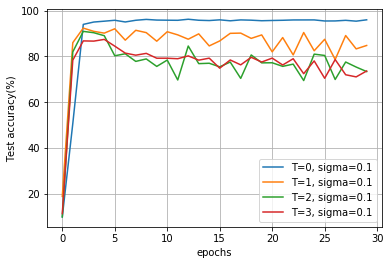

In [22]:

plot_acc = np.mean(acc_test_arr, axis=1)
print(acc_test_arr.shape)
print(plot_acc.shape)

plt.plot(plot_acc[0,:],label='T=0, sigma=0.1')
plt.plot(plot_acc[1,:],label='T=1, sigma=0.1')
plt.plot(plot_acc[2,:],label='T=2, sigma=0.1')
plt.plot(plot_acc[3,:],label='T=3, sigma=0.1')
# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

import pickle

filehandler = open("./plot/MNIST_LeNet_N15_K6_T_0_1_2_3_sigma0-1_test_acc","wb")
pickle.dump(acc_test_arr,filehandler)

## 1.2. Encoding MNIST (N=15, K=6, T=[0,1,...,7], Sigma=[0, 0.1, 1, 10, 100])

In [24]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N = args.num_users
K = args.num_partition




# training
loss_train_arr = []
loss_test_arr = []
acc_test_arr = []
net_best = None
best_loss = None

N_trials = 1
N_epochs = 30

# m_array = np.array(range(4,16)) # m is the number of received result @ master
T_array = np.array([0,1,2,3]) # m is the number of received result @ master
sigma_array = np.array([0, 0.1, 1, 10, 100])


loss_test_arr = np.empty((len(T_array),len(sigma_array),N_trials,N_epochs))
acc_test_arr  = np.empty((len(T_array),len(sigma_array),N_trials,N_epochs))

for T_idx in range(len(T_array)):
    


    
    T = T_array[T_idx]
    
    if T == 0:
        Noise_Alloc = []
    elif T == 1:
        Noise_Alloc = [3]
    elif T == 2:
        Noise_Alloc = [2,5]
    else:
        Noise_Alloc = [2,4,7] # np.random.choice(range(K+T), T, replace=False)
        
    Signal_Alloc = []
    for i in range(K+T):
        if i not in Noise_Alloc:
            Signal_Alloc.append(i)

    j_array = np.array(range(K+T))
    # print("j: ",(2*j_array+1)*math.pi/2/K,'\n')

    alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))

    i_array = np.array(range(N))
    z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
    
    for sigma_idx in range(len(sigma_array)):
        
        sigma = sigma_array[sigma_idx]

        X_tilde,a,b = BACC_Enc_withNoise(encoding_input_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_withNoise(encoding_label_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist2(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr[T_idx][sigma_idx][trial_idx][iter] = acc_test
                loss_test_arr[T_idx][sigma_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

@BACC_Enc: N,K,T, m_i= 15 6 0 10000 

@BACC_Enc: N,K, m_i= 15 6 10000 

@BACC_Enc: N,K,T, m_i= 15 6 0 10000 

@BACC_Enc: N,K, m_i= 15 6 10000 

(T, sigma)= 0 0.0 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.2916 
Accuracy: 5728/10000 (57.28%)

Round   1, Average loss 2.292 Test accuracy 57.280
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.3518 
Accuracy: 9048/10000 (90.48%)

Round   2, Average loss 1.352 Test accuracy 90.480
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.8508 
Accuracy: 9479/10000 (94.79%)

Round   3, Average loss 0.851 Test accuracy 94.790
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2926 
Accuracy: 9479/1


Test set: Average loss: 0.1386 
Accuracy: 9617/10000 (96.17%)

Round  14, Average loss 0.139 Test accuracy 96.170
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1463 
Accuracy: 9558/10000 (95.58%)

Round  15, Average loss 0.146 Test accuracy 95.580
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1402 
Accuracy: 9604/10000 (96.04%)

Round  16, Average loss 0.140 Test accuracy 96.040
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1503 
Accuracy: 9589/10000 (95.89%)

Round  17, Average loss 0.150 Test accuracy 95.890
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1577 
Accuracy: 9599/10000 (95.99%)

Round  18, Average loss 0.158 Test accuracy 95.990
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1851 
Accuracy: 9579/10000 (95.79%)

Round  19, Average loss 0.185 Test accuracy 95

@BACC_Enc: N,K,T, m_i= 15 6 0 10000 

@BACC_Enc: N,K, m_i= 15 6 10000 

(T, sigma)= 0 10.0 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3021 
Accuracy: 1175/10000 (11.75%)

Round   1, Average loss 2.302 Test accuracy 11.750
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.0620 
Accuracy: 8376/10000 (83.76%)

Round   2, Average loss 2.062 Test accuracy 83.760
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.4038 
Accuracy: 9493/10000 (94.93%)

Round   3, Average loss 0.404 Test accuracy 94.930
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2734 
Accuracy: 9533/10000 (95.33%)

Round   4, Average loss 0.273 Test accuracy 95.330
selec


Test set: Average loss: 0.1889 
Accuracy: 9556/10000 (95.56%)

Round  15, Average loss 0.189 Test accuracy 95.560
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1809 
Accuracy: 9590/10000 (95.90%)

Round  16, Average loss 0.181 Test accuracy 95.900
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1871 
Accuracy: 9547/10000 (95.47%)

Round  17, Average loss 0.187 Test accuracy 95.470
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2031 
Accuracy: 9579/10000 (95.79%)

Round  18, Average loss 0.203 Test accuracy 95.790
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1692 
Accuracy: 9560/10000 (95.60%)

Round  19, Average loss 0.169 Test accuracy 95.600
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1932 
Accuracy: 9594/10000 (95.94%)

Round  20, Average loss 0.193 Test accuracy 95

@BACC_Enc: N,K,T, m_i= 15 6 1 10000 

@BACC_Enc: N,K, m_i= 15 7 10000 

(T, sigma)= 1 0.1 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.0442 
Accuracy: 8311/10000 (83.11%)

Round   1, Average loss 2.044 Test accuracy 83.110
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.3808 
Accuracy: 9179/10000 (91.79%)

Round   2, Average loss 0.381 Test accuracy 91.790
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.3092 
Accuracy: 9050/10000 (90.50%)

Round   3, Average loss 0.309 Test accuracy 90.500
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.3410 
Accuracy: 8897/10000 (88.97%)

Round   4, Average loss 0.341 Test accuracy 88.970
select


Test set: Average loss: 0.6294 
Accuracy: 9336/10000 (93.36%)

Round  15, Average loss 0.629 Test accuracy 93.360
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.5495 
Accuracy: 9298/10000 (92.98%)

Round  16, Average loss 0.549 Test accuracy 92.980
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.7823 
Accuracy: 9260/10000 (92.60%)

Round  17, Average loss 0.782 Test accuracy 92.600
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.5153 
Accuracy: 9310/10000 (93.10%)

Round  18, Average loss 0.515 Test accuracy 93.100
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.7243 
Accuracy: 9286/10000 (92.86%)

Round  19, Average loss 0.724 Test accuracy 92.860
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.5526 
Accuracy: 9252/10000 (92.52%)

Round  20, Average loss 0.553 Test accuracy 92

@BACC_Enc: N,K,T, m_i= 15 6 1 10000 

@BACC_Enc: N,K, m_i= 15 7 10000 

(T, sigma)= 1 100.0 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 1010/10000 (10.10%)

Round   1, Average loss 2.303 Test accuracy 10.100
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3022 
Accuracy: 2877/10000 (28.77%)

Round   2, Average loss 2.302 Test accuracy 28.770
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3013 
Accuracy: 1973/10000 (19.73%)

Round   3, Average loss 2.301 Test accuracy 19.730
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3003 
Accuracy: 2598/10000 (25.98%)

Round   4, Average loss 2.300 Test accuracy 25.980
sele


Test set: Average loss: 27.1252 
Accuracy: 7475/10000 (74.75%)

Round  15, Average loss 27.125 Test accuracy 74.750
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 35.3044 
Accuracy: 7200/10000 (72.00%)

Round  16, Average loss 35.304 Test accuracy 72.000
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 16.7483 
Accuracy: 8117/10000 (81.17%)

Round  17, Average loss 16.748 Test accuracy 81.170
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 24.2332 
Accuracy: 7456/10000 (74.56%)

Round  18, Average loss 24.233 Test accuracy 74.560
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 27.9509 
Accuracy: 7449/10000 (74.49%)

Round  19, Average loss 27.951 Test accuracy 74.490
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 26.4181 
Accuracy: 7434/10000 (74.34%)

Round  20, Average loss 26.418 Test

@BACC_Enc: N,K, m_i= 15 8 10000 

@BACC_Enc: N,K,T, m_i= 15 6 2 10000 

@BACC_Enc: N,K, m_i= 15 8 10000 

(T, sigma)= 2 1.0 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3025 
Accuracy: 1491/10000 (14.91%)

Round   0, Average loss 2.302 Test accuracy 14.910
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.8664 
Accuracy: 8078/10000 (80.78%)

Round   1, Average loss 0.866 Test accuracy 80.780
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.3513 
Accuracy: 9012/10000 (90.12%)

Round   2, Average loss 1.351 Test accuracy 90.120
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 3.2285 
Accuracy: 8892/10000 (88.92%)

Round   3, Average loss 3.229 Test accuracy 88.920
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 5.0852 
Accuracy: 8430/10000 (84.30%)

Round   4, Average l


Test set: Average loss: 2.3023 
Accuracy: 1135/10000 (11.35%)

Round  14, Average loss 2.302 Test accuracy 11.350
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3023 
Accuracy: 1135/10000 (11.35%)

Round  15, Average loss 2.302 Test accuracy 11.350
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3024 
Accuracy: 1135/10000 (11.35%)

Round  16, Average loss 2.302 Test accuracy 11.350
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3025 
Accuracy: 1135/10000 (11.35%)

Round  17, Average loss 2.302 Test accuracy 11.350
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3025 
Accuracy: 1135/10000 (11.35%)

Round  18, Average loss 2.303 Test accuracy 11.350
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3023 
Accuracy: 1135/10000 (11.35%)

Round  19, Average loss 2.302 Test accuracy 11

@BACC_Enc: N,K, m_i= 15 9 10000 

@BACC_Enc: N,K,T, m_i= 15 6 3 10000 

@BACC_Enc: N,K, m_i= 15 9 10000 

(T, sigma)= 3 0.0 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 1248/10000 (12.48%)

Round   0, Average loss 2.303 Test accuracy 12.480
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.0264 
Accuracy: 7856/10000 (78.56%)

Round   1, Average loss 1.026 Test accuracy 78.560
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 13.5720 
Accuracy: 7607/10000 (76.07%)

Round   2, Average loss 13.572 Test accuracy 76.070
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 8.7369 
Accuracy: 8783/10000 (87.83%)

Round   3, Average loss 8.737 Test accuracy 87.830
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 10.6107 
Accuracy: 8721/10000 (87.21%)

Round   4, Averag


Test set: Average loss: 29.7720 
Accuracy: 7704/10000 (77.04%)

Round  14, Average loss 29.772 Test accuracy 77.040
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 26.7535 
Accuracy: 7801/10000 (78.01%)

Round  15, Average loss 26.754 Test accuracy 78.010
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 33.7727 
Accuracy: 7545/10000 (75.45%)

Round  16, Average loss 33.773 Test accuracy 75.450
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 23.7901 
Accuracy: 7887/10000 (78.87%)

Round  17, Average loss 23.790 Test accuracy 78.870
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 34.6341 
Accuracy: 7558/10000 (75.58%)

Round  18, Average loss 34.634 Test accuracy 75.580
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 29.6365 
Accuracy: 7679/10000 (76.79%)

Round  19, Average loss 29.636 Test


Test set: Average loss: 15.3082 
Accuracy: 7875/10000 (78.75%)

Round  29, Average loss 15.308 Test accuracy 78.750
@BACC_Enc: N,K,T, m_i= 15 6 3 10000 

@BACC_Enc: N,K, m_i= 15 9 10000 

@BACC_Enc: N,K,T, m_i= 15 6 3 10000 

@BACC_Enc: N,K, m_i= 15 9 10000 

(T, sigma)= 3 10.0 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 1010/10000 (10.10%)

Round   1, Average loss 2.303 Test accuracy 10.100
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 1010/10000 (10.10%)

Round   2, Average loss 2.303 Test accuracy 10.100
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   3, Average loss 2.303 Test accuracy 9.8


Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  14, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 1009/10000 (10.09%)

Round  15, Average loss 2.303 Test accuracy 10.090
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 1009/10000 (10.09%)

Round  16, Average loss 2.303 Test accuracy 10.090
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 1009/10000 (10.09%)

Round  17, Average loss 2.303 Test accuracy 10.090
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 1009/10000 (10.09%)

Round  18, Average loss 2.303 Test accuracy 10.090
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 1009/10000 (10.09%)

Round  19, Average loss 2.303 Test accuracy 10.09

In [25]:
filehandler = open("./plot/MNIST_LeNet_N15_K6_T_0_to_3_sigma_0_to_100_test_acc","wb")
pickle.dump(acc_test_arr,filehandler)

(4, 5, 1, 30)
(4, 5, 30)


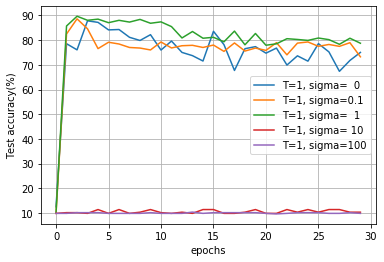

In [32]:
plot_acc = np.mean(acc_test_arr, axis=2)
print(acc_test_arr.shape)
print(plot_acc.shape)

T_sel = 3

plt.plot(plot_acc[T_sel,0,:],label='T=1, sigma=  0')
plt.plot(plot_acc[T_sel,1,:],label='T=1, sigma=0.1')
plt.plot(plot_acc[T_sel,2,:],label='T=1, sigma=  1')
plt.plot(plot_acc[T_sel,3,:],label='T=1, sigma= 10')
plt.plot(plot_acc[T_sel,4,:],label='T=1, sigma=100')
# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

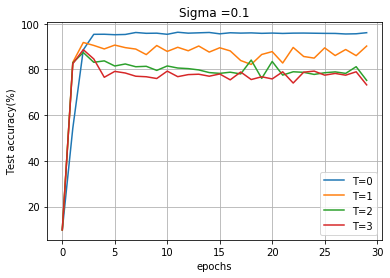

In [37]:
sigma_sel = 1

title_name = 'Sigma ='+str(sigma_array[sigma_sel])
plt.plot(plot_acc[0,sigma_sel,:],label='T=0')
plt.plot(plot_acc[1,sigma_sel,:],label='T=1')
plt.plot(plot_acc[2,sigma_sel,:],label='T=2')
plt.plot(plot_acc[3,sigma_sel,:],label='T=3')
# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

In [38]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N = args.num_users
K = args.num_partition




# training



N_trials = 1
N_epochs = 30

# m_array = np.array(range(4,16)) # m is the number of received result @ master
T_array = np.array([4,5,6,7]) # m is the number of received result @ master
sigma_array = np.array([0, 0.1, 1, 10, 100])


loss_test_arr_v2 = np.empty((len(T_array),len(sigma_array),N_trials,N_epochs))
acc_test_arr_v2  = np.empty((len(T_array),len(sigma_array),N_trials,N_epochs))

for T_idx in range(len(T_array)):
    


    
    T = T_array[T_idx]
    
    if T == 0:
        Noise_Alloc = []
    elif T == 1:
        Noise_Alloc = [3]
    elif T == 2:
        Noise_Alloc = [2,5]
    elif T == 3:
        Noise_Alloc = [2,4,7]
    elif T == 4:
        Noise_Alloc = [1,3,5,8]
    elif T == 5:
        Noise_Alloc = [1,3,5,7,9]
    elif T == 6:
        Noise_Alloc = [2,4,5,7,9,10]
    elif T == 7:
        Noise_Alloc = [1,3,5,7,9,10,12] # np.random.choice(range(K+T), T, replace=False)
    else:
        Noise_Alloc = np.random.choice(range(K+T), T, replace=False)
        
    Signal_Alloc = []
    for i in range(K+T):
        if i not in Noise_Alloc:
            Signal_Alloc.append(i)

    j_array = np.array(range(K+T))
    # print("j: ",(2*j_array+1)*math.pi/2/K,'\n')

    alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))

    i_array = np.array(range(N))
    z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
    
    for sigma_idx in range(len(sigma_array)):
        
        sigma = sigma_array[sigma_idx]

        X_tilde,a,b = BACC_Enc_withNoise(encoding_input_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_withNoise(encoding_label_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist2(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_v2[T_idx][sigma_idx][trial_idx][iter] = acc_test
                loss_test_arr_v2[T_idx][sigma_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

@BACC_Enc: N,K,T, m_i= 15 6 4 10000 

@BACC_Enc: N,K, m_i= 15 10 10000 

@BACC_Enc: N,K,T, m_i= 15 6 4 10000 

@BACC_Enc: N,K, m_i= 15 10 10000 

(T, sigma)= 4 0.0 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 14.9965 
Accuracy: 1581/10000 (15.81%)

Round   0, Average loss 14.996 Test accuracy 15.810
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.8523 
Accuracy: 3446/10000 (34.46%)

Round   1, Average loss 1.852 Test accuracy 34.460
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 27.0250 
Accuracy: 1232/10000 (12.32%)

Round   2, Average loss 27.025 Test accuracy 12.320
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 8.5783 
Accuracy: 4790/10000 (47.90%)

Round   3, Average loss 8.578 Test accuracy 47.900
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 12.9562 
Accura


Test set: Average loss: 17.5357 
Accuracy: 5122/10000 (51.22%)

Round  14, Average loss 17.536 Test accuracy 51.220
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 28.1068 
Accuracy: 3511/10000 (35.11%)

Round  15, Average loss 28.107 Test accuracy 35.110
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 14.6928 
Accuracy: 5475/10000 (54.75%)

Round  16, Average loss 14.693 Test accuracy 54.750
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 31.1987 
Accuracy: 3136/10000 (31.36%)

Round  17, Average loss 31.199 Test accuracy 31.360
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 11.7532 
Accuracy: 5822/10000 (58.22%)

Round  18, Average loss 11.753 Test accuracy 58.220
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 37.5537 
Accuracy: 2537/10000 (25.37%)

Round  19, Average loss 37.554 Test


Test set: Average loss: 0.9296 
Accuracy: 7558/10000 (75.58%)

Round  29, Average loss 0.930 Test accuracy 75.580
@BACC_Enc: N,K,T, m_i= 15 6 4 10000 

@BACC_Enc: N,K, m_i= 15 10 10000 

@BACC_Enc: N,K,T, m_i= 15 6 4 10000 

@BACC_Enc: N,K, m_i= 15 10 10000 

(T, sigma)= 4 10.0 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   1, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   2, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   3, Average loss 2.303 Test accuracy 9.800
sel


Test set: Average loss: 2.3025 
Accuracy: 982/10000 (9.82%)

Round  14, Average loss 2.302 Test accuracy 9.820
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3038 
Accuracy: 1135/10000 (11.35%)

Round  15, Average loss 2.304 Test accuracy 11.350
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3067 
Accuracy: 1135/10000 (11.35%)

Round  16, Average loss 2.307 Test accuracy 11.350
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  17, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 461/10000 (4.61%)

Round  18, Average loss 2.303 Test accuracy 4.610
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 923/10000 (9.23%)

Round  19, Average loss 2.303 Test accuracy 9.230
selecte

@BACC_Enc: N,K, m_i= 15 11 10000 

@BACC_Enc: N,K,T, m_i= 15 6 5 10000 

@BACC_Enc: N,K, m_i= 15 11 10000 

(T, sigma)= 5 0.1 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.4387 
Accuracy: 9104/10000 (91.04%)

Round   1, Average loss 0.439 Test accuracy 91.040
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.8369 
Accuracy: 9300/10000 (93.00%)

Round   2, Average loss 1.837 Test accuracy 93.000
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 3.7551 
Accuracy: 9253/10000 (92.53%)

Round   3, Average loss 3.755 Test accuracy 92.530
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 4.7320 
Accuracy: 9237/10000 (92.37%)

Round   4, Average lo


Test set: Average loss: 0.2758 
Accuracy: 9328/10000 (93.28%)

Round  14, Average loss 0.276 Test accuracy 93.280
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2764 
Accuracy: 9303/10000 (93.03%)

Round  15, Average loss 0.276 Test accuracy 93.030
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2863 
Accuracy: 9320/10000 (93.20%)

Round  16, Average loss 0.286 Test accuracy 93.200
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2655 
Accuracy: 9355/10000 (93.55%)

Round  17, Average loss 0.266 Test accuracy 93.550
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.3169 
Accuracy: 9292/10000 (92.92%)

Round  18, Average loss 0.317 Test accuracy 92.920
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2812 
Accuracy: 9322/10000 (93.22%)

Round  19, Average loss 0.281 Test accuracy 93

@BACC_Enc: N,K, m_i= 15 11 10000 

@BACC_Enc: N,K,T, m_i= 15 6 5 10000 

@BACC_Enc: N,K, m_i= 15 11 10000 

(T, sigma)= 5 100.0 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3111 
Accuracy: 903/10000 (9.03%)

Round   0, Average loss 2.311 Test accuracy 9.030
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 892/10000 (8.92%)

Round   1, Average loss 2.303 Test accuracy 8.920
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   2, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   3, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 974/10000 (9.74%)

Round   4, Average loss 2.303 


Test set: Average loss: 16.2418 
Accuracy: 7893/10000 (78.93%)

Round  15, Average loss 16.242 Test accuracy 78.930
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 19.7175 
Accuracy: 5155/10000 (51.55%)

Round  16, Average loss 19.717 Test accuracy 51.550
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 15.6559 
Accuracy: 7804/10000 (78.04%)

Round  17, Average loss 15.656 Test accuracy 78.040
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 20.6766 
Accuracy: 5043/10000 (50.43%)

Round  18, Average loss 20.677 Test accuracy 50.430
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 17.7279 
Accuracy: 7452/10000 (74.52%)

Round  19, Average loss 17.728 Test accuracy 74.520
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 20.9455 
Accuracy: 4936/10000 (49.36%)

Round  20, Average loss 20.945 Test

@BACC_Enc: N,K, m_i= 15 12 10000 

@BACC_Enc: N,K,T, m_i= 15 6 6 10000 

@BACC_Enc: N,K, m_i= 15 12 10000 

(T, sigma)= 6 1.0 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3025 
Accuracy: 1135/10000 (11.35%)

Round   0, Average loss 2.302 Test accuracy 11.350
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.7282 
Accuracy: 7932/10000 (79.32%)

Round   1, Average loss 1.728 Test accuracy 79.320
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.5758 
Accuracy: 8942/10000 (89.42%)

Round   2, Average loss 0.576 Test accuracy 89.420
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.9030 
Accuracy: 9086/10000 (90.86%)

Round   3, Average loss 0.903 Test accuracy 90.860
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.1458 
Accuracy: 9037/10000 (90.37%)

Round   4, Average


Test set: Average loss: 2.3025 
Accuracy: 1135/10000 (11.35%)

Round  14, Average loss 2.303 Test accuracy 11.350
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  15, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  16, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 982/10000 (9.82%)

Round  17, Average loss 2.303 Test accuracy 9.820
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  18, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  19, Average loss 2.303 Test accuracy 9.800
selected u

@BACC_Enc: N,K, m_i= 15 13 10000 

@BACC_Enc: N,K,T, m_i= 15 6 7 10000 

@BACC_Enc: N,K, m_i= 15 13 10000 

(T, sigma)= 7 0.0 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.2936 
Accuracy: 1699/10000 (16.99%)

Round   0, Average loss 2.294 Test accuracy 16.990
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.6331 
Accuracy: 8346/10000 (83.46%)

Round   1, Average loss 0.633 Test accuracy 83.460
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.6112 
Accuracy: 8963/10000 (89.63%)

Round   2, Average loss 0.611 Test accuracy 89.630
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.3674 
Accuracy: 8662/10000 (86.62%)

Round   3, Average loss 1.367 Test accuracy 86.620
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.1592 
Accuracy: 8813/10000 (88.13%)

Round   4, Average


Test set: Average loss: 2.9036 
Accuracy: 8702/10000 (87.02%)

Round  14, Average loss 2.904 Test accuracy 87.020
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 7.4263 
Accuracy: 7517/10000 (75.17%)

Round  15, Average loss 7.426 Test accuracy 75.170
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 3.1837 
Accuracy: 8666/10000 (86.66%)

Round  16, Average loss 3.184 Test accuracy 86.660
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.6444 
Accuracy: 8572/10000 (85.72%)

Round  17, Average loss 2.644 Test accuracy 85.720
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 6.5372 
Accuracy: 8037/10000 (80.37%)

Round  18, Average loss 6.537 Test accuracy 80.370
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 3.9011 
Accuracy: 8056/10000 (80.56%)

Round  19, Average loss 3.901 Test accuracy 80

@BACC_Enc: N,K, m_i= 15 13 10000 

@BACC_Enc: N,K,T, m_i= 15 6 7 10000 

@BACC_Enc: N,K, m_i= 15 13 10000 

(T, sigma)= 7 10.0 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   1, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   2, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   3, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   4, Average loss 2.303 T


Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  15, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3053 
Accuracy: 1135/10000 (11.35%)

Round  16, Average loss 2.305 Test accuracy 11.350
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 1010/10000 (10.10%)

Round  17, Average loss 2.303 Test accuracy 10.100
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  18, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 468/10000 (4.68%)

Round  19, Average loss 2.303 Test accuracy 4.680
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  20, Average loss 2.303 Test accuracy 9.800
selecte

In [39]:
plot_acc_v2 = np.mean(acc_test_arr_v2, axis=2)
# print(acc_test_arr.shape)
print(plot_acc_v2.shape)

(4, 5, 30)


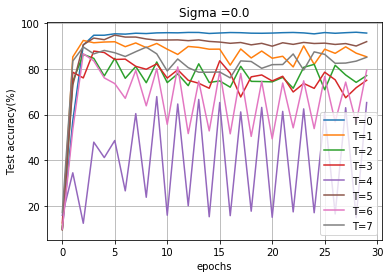

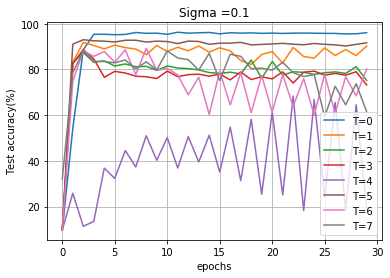

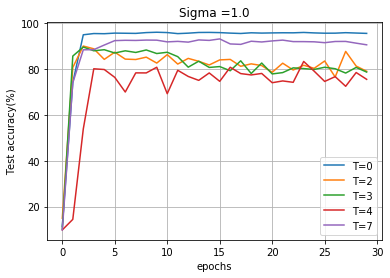

In [53]:
sigma_sel = 0

title_name = 'Sigma ='+str(sigma_array[sigma_sel])
plt.plot(plot_acc[0,sigma_sel,:],label='T=0')
plt.plot(plot_acc[1,sigma_sel,:],label='T=1')
plt.plot(plot_acc[2,sigma_sel,:],label='T=2')
plt.plot(plot_acc[3,sigma_sel,:],label='T=3')
plt.plot(plot_acc_v2[0,sigma_sel,:],label='T=4')
plt.plot(plot_acc_v2[1,sigma_sel,:],label='T=5')
plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=6')
plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=7')
# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

sigma_sel = 1

title_name = 'Sigma ='+str(sigma_array[sigma_sel])
plt.plot(plot_acc[0,sigma_sel,:],label='T=0')
plt.plot(plot_acc[1,sigma_sel,:],label='T=1')
plt.plot(plot_acc[2,sigma_sel,:],label='T=2')
plt.plot(plot_acc[3,sigma_sel,:],label='T=3')
plt.plot(plot_acc_v2[0,sigma_sel,:],label='T=4')
plt.plot(plot_acc_v2[1,sigma_sel,:],label='T=5')
plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=6')
plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=7')
# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

sigma_sel = 2

title_name = 'Sigma ='+str(sigma_array[sigma_sel])
plt.plot(plot_acc[0,sigma_sel,:],label='T=0')
# plt.plot(plot_acc[1,sigma_sel,:],label='T=1')
plt.plot(plot_acc[2,sigma_sel,:],label='T=2')
plt.plot(plot_acc[3,sigma_sel,:],label='T=3')
plt.plot(plot_acc_v2[0,sigma_sel,:],label='T=4')
# plt.plot(plot_acc_v2[1,sigma_sel,:],label='T=5')
# plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=6')
plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=7')
# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

In [65]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N = args.num_users
K = args.num_partition




# training



N_trials = 1
N_epochs = 30

# m_array = np.array(range(4,16)) # m is the number of received result @ master
T_array = np.array([0,1,2,3,4,5,6,7,8,9,10]) # m is the number of received result @ master
sigma_array = np.array([0.1, 1])


loss_test_arr_v2 = np.empty((len(T_array),len(sigma_array),N_trials,N_epochs))
acc_test_arr_v2  = np.empty((len(T_array),len(sigma_array),N_trials,N_epochs))

for T_idx in range(len(T_array)):
    


    
    T = T_array[T_idx]
    
    if T == 0:
        Noise_Alloc = []
    elif T == 1:
        Noise_Alloc = [3]
    elif T == 2:
        Noise_Alloc = [0,7]
    elif T == 3:
        Noise_Alloc = [0,4,8]
    elif T == 4:
        Noise_Alloc = [0,3,6,9]
    elif T == 5:
        Noise_Alloc = [0,3,5,7,10]
    elif T == 6:
        Noise_Alloc = [0,2,4,7,9,11]
    elif T == 7:
        Noise_Alloc = [0,2,4,6,8,10,12] # np.random.choice(range(K+T), T, replace=False)
    elif T == 8:
        Noise_Alloc = [0,2,4,6,7,9,11,13] # np.random.choice(range(K+T), T, replace=False)
    elif T == 9:
        Noise_Alloc = [0,2,4,5,7,9,10,12,14] # np.random.choice(range(K+T), T, replace=False)
    elif T == 10:
        Noise_Alloc = [0,2,4,5,7,8,10,11,13,15] # np.random.choice(range(K+T), T, replace=False)
    else:
        Noise_Alloc = np.random.choice(range(K+T), T, replace=False)
        
    Signal_Alloc = []
    for i in range(K+T):
        if i not in Noise_Alloc:
            Signal_Alloc.append(i)

    j_array = np.array(range(K+T))
    # print("j: ",(2*j_array+1)*math.pi/2/K,'\n')

    alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))

    i_array = np.array(range(N))
    z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
    
    for sigma_idx in range(len(sigma_array)):
        
        sigma = sigma_array[sigma_idx]

        X_tilde,a,b = BACC_Enc_withNoise(encoding_input_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_withNoise(encoding_label_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist2(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_v2[T_idx][sigma_idx][trial_idx][iter] = acc_test
                loss_test_arr_v2[T_idx][sigma_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

@BACC_Enc: N,K,T, m_i= 15 6 0 10000 

@BACC_Enc: N,K, m_i= 15 6 10000 

@BACC_Enc: N,K,T, m_i= 15 6 0 10000 

@BACC_Enc: N,K, m_i= 15 6 10000 

(T, sigma)= 0 0.1 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.2580 
Accuracy: 5752/10000 (57.52%)

Round   1, Average loss 2.258 Test accuracy 57.520
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2482 
Accuracy: 9458/10000 (94.58%)

Round   2, Average loss 0.248 Test accuracy 94.580
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1686 
Accuracy: 9536/10000 (95.36%)

Round   3, Average loss 0.169 Test accuracy 95.360
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1489 
Accuracy: 9576/1


Test set: Average loss: 0.1594 
Accuracy: 9551/10000 (95.51%)

Round  14, Average loss 0.159 Test accuracy 95.510
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1453 
Accuracy: 9599/10000 (95.99%)

Round  15, Average loss 0.145 Test accuracy 95.990
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1641 
Accuracy: 9569/10000 (95.69%)

Round  16, Average loss 0.164 Test accuracy 95.690
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1691 
Accuracy: 9579/10000 (95.79%)

Round  17, Average loss 0.169 Test accuracy 95.790
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1604 
Accuracy: 9576/10000 (95.76%)

Round  18, Average loss 0.160 Test accuracy 95.760
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1605 
Accuracy: 9547/10000 (95.47%)

Round  19, Average loss 0.161 Test accuracy 95

@BACC_Enc: N,K, m_i= 15 7 10000 

@BACC_Enc: N,K,T, m_i= 15 6 1 10000 

@BACC_Enc: N,K, m_i= 15 7 10000 

(T, sigma)= 1 1.0 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.2934 
Accuracy: 4966/10000 (49.66%)

Round   1, Average loss 2.293 Test accuracy 49.660
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.1874 
Accuracy: 8942/10000 (89.42%)

Round   2, Average loss 1.187 Test accuracy 89.420
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.6606 
Accuracy: 9131/10000 (91.31%)

Round   3, Average loss 0.661 Test accuracy 91.310
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.7435 
Accuracy: 9278/10000 (92.78%)

Round   4, Average loss


Test set: Average loss: 3.8800 
Accuracy: 8217/10000 (82.17%)

Round  14, Average loss 3.880 Test accuracy 82.170
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 26.7484 
Accuracy: 5926/10000 (59.26%)

Round  15, Average loss 26.748 Test accuracy 59.260
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 10.1414 
Accuracy: 8009/10000 (80.09%)

Round  16, Average loss 10.141 Test accuracy 80.090
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 41.5282 
Accuracy: 5071/10000 (50.71%)

Round  17, Average loss 41.528 Test accuracy 50.710
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 5.1043 
Accuracy: 8621/10000 (86.21%)

Round  18, Average loss 5.104 Test accuracy 86.210
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 69.5499 
Accuracy: 3294/10000 (32.94%)

Round  19, Average loss 69.550 Test acc


Test set: Average loss: 0.2953 
Accuracy: 9072/10000 (90.72%)

Round  29, Average loss 0.295 Test accuracy 90.720
@BACC_Enc: N,K,T, m_i= 15 6 3 10000 

@BACC_Enc: N,K, m_i= 15 9 10000 

@BACC_Enc: N,K,T, m_i= 15 6 3 10000 

@BACC_Enc: N,K, m_i= 15 9 10000 

(T, sigma)= 3 0.1 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.2816 
Accuracy: 1032/10000 (10.32%)

Round   1, Average loss 2.282 Test accuracy 10.320
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.1434 
Accuracy: 5968/10000 (59.68%)

Round   2, Average loss 1.143 Test accuracy 59.680
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.1342 
Accuracy: 7932/10000 (79.32%)

Round   3, Average loss 1.134 Test accuracy 79.3


Test set: Average loss: 0.2342 
Accuracy: 9383/10000 (93.83%)

Round  14, Average loss 0.234 Test accuracy 93.830
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2214 
Accuracy: 9375/10000 (93.75%)

Round  15, Average loss 0.221 Test accuracy 93.750
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2671 
Accuracy: 9366/10000 (93.66%)

Round  16, Average loss 0.267 Test accuracy 93.660
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2318 
Accuracy: 9386/10000 (93.86%)

Round  17, Average loss 0.232 Test accuracy 93.860
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2299 
Accuracy: 9399/10000 (93.99%)

Round  18, Average loss 0.230 Test accuracy 93.990
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2078 
Accuracy: 9423/10000 (94.23%)

Round  19, Average loss 0.208 Test accuracy 94


Test set: Average loss: 49.5463 
Accuracy: 8006/10000 (80.06%)

Round  29, Average loss 49.546 Test accuracy 80.060
@BACC_Enc: N,K,T, m_i= 15 6 4 10000 

@BACC_Enc: N,K, m_i= 15 10 10000 

@BACC_Enc: N,K,T, m_i= 15 6 4 10000 

@BACC_Enc: N,K, m_i= 15 10 10000 

(T, sigma)= 4 1.0 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3024 
Accuracy: 1135/10000 (11.35%)

Round   0, Average loss 2.302 Test accuracy 11.350
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.6528 
Accuracy: 8525/10000 (85.25%)

Round   1, Average loss 0.653 Test accuracy 85.250
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.1683 
Accuracy: 8910/10000 (89.10%)

Round   2, Average loss 1.168 Test accuracy 89.100
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.9260 
Accuracy: 9041/10000 (90.41%)

Round   3, Average loss 1.926 Test accura


Test set: Average loss: 15.1201 
Accuracy: 4289/10000 (42.89%)

Round  13, Average loss 15.120 Test accuracy 42.890
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 19.1298 
Accuracy: 5892/10000 (58.92%)

Round  14, Average loss 19.130 Test accuracy 58.920
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 17.4603 
Accuracy: 4168/10000 (41.68%)

Round  15, Average loss 17.460 Test accuracy 41.680
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 23.8551 
Accuracy: 5266/10000 (52.66%)

Round  16, Average loss 23.855 Test accuracy 52.660
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 22.5567 
Accuracy: 4129/10000 (41.29%)

Round  17, Average loss 22.557 Test accuracy 41.290
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 22.9932 
Accuracy: 5008/10000 (50.08%)

Round  18, Average loss 22.993 Test


Test set: Average loss: 0.7765 
Accuracy: 7723/10000 (77.23%)

Round  28, Average loss 0.777 Test accuracy 77.230
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.6746 
Accuracy: 8209/10000 (82.09%)

Round  29, Average loss 0.675 Test accuracy 82.090
@BACC_Enc: N,K,T, m_i= 15 6 6 10000 

@BACC_Enc: N,K, m_i= 15 12 10000 

@BACC_Enc: N,K,T, m_i= 15 6 6 10000 

@BACC_Enc: N,K, m_i= 15 12 10000 

(T, sigma)= 6 0.1 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.2741 
Accuracy: 988/10000 (9.88%)

Round   0, Average loss 2.274 Test accuracy 9.880
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.5198 
Accuracy: 7135/10000 (71.35%)

Round   1, Average loss 2.520 Test accuracy 71.350
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3656 
Accuracy: 7837/10000 (78.37%)

Round   2, Average loss 2.366 Test accuracy 78


Test set: Average loss: 0.7455 
Accuracy: 8426/10000 (84.26%)

Round  12, Average loss 0.746 Test accuracy 84.260
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.6196 
Accuracy: 8765/10000 (87.65%)

Round  13, Average loss 0.620 Test accuracy 87.650
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.5563 
Accuracy: 8844/10000 (88.44%)

Round  14, Average loss 0.556 Test accuracy 88.440
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.6063 
Accuracy: 8764/10000 (87.64%)

Round  15, Average loss 0.606 Test accuracy 87.640
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.0159 
Accuracy: 8035/10000 (80.35%)

Round  16, Average loss 1.016 Test accuracy 80.350
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.6583 
Accuracy: 8650/10000 (86.50%)

Round  17, Average loss 0.658 Test accuracy 86


Test set: Average loss: 2.4329 
Accuracy: 9172/10000 (91.72%)

Round  28, Average loss 2.433 Test accuracy 91.720
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 3.0946 
Accuracy: 8836/10000 (88.36%)

Round  29, Average loss 3.095 Test accuracy 88.360
@BACC_Enc: N,K,T, m_i= 15 6 7 10000 

@BACC_Enc: N,K, m_i= 15 13 10000 

@BACC_Enc: N,K,T, m_i= 15 6 7 10000 

@BACC_Enc: N,K, m_i= 15 13 10000 

(T, sigma)= 7 1.0 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3025 
Accuracy: 1010/10000 (10.10%)

Round   0, Average loss 2.302 Test accuracy 10.100
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.2296 
Accuracy: 6832/10000 (68.32%)

Round   1, Average loss 2.230 Test accuracy 68.320
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.5288 
Accuracy: 9164/10000 (91.64%)

Round   2, Average loss 0.529 Test accuracy


Test set: Average loss: 0.8497 
Accuracy: 7429/10000 (74.29%)

Round  12, Average loss 0.850 Test accuracy 74.290
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.2462 
Accuracy: 7728/10000 (77.28%)

Round  13, Average loss 1.246 Test accuracy 77.280
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.8032 
Accuracy: 7656/10000 (76.56%)

Round  14, Average loss 0.803 Test accuracy 76.560
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.9532 
Accuracy: 7323/10000 (73.23%)

Round  15, Average loss 0.953 Test accuracy 73.230
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.7864 
Accuracy: 7536/10000 (75.36%)

Round  16, Average loss 0.786 Test accuracy 75.360
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.1986 
Accuracy: 7661/10000 (76.61%)

Round  17, Average loss 1.199 Test accuracy 76


Test set: Average loss: 1.8256 
Accuracy: 9233/10000 (92.33%)

Round  28, Average loss 1.826 Test accuracy 92.330
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.7586 
Accuracy: 9200/10000 (92.00%)

Round  29, Average loss 1.759 Test accuracy 92.000
@BACC_Enc: N,K,T, m_i= 15 6 9 10000 

@BACC_Enc: N,K, m_i= 15 15 10000 

@BACC_Enc: N,K,T, m_i= 15 6 9 10000 

@BACC_Enc: N,K, m_i= 15 15 10000 

(T, sigma)= 9 0.1 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.1573 
Accuracy: 3347/10000 (33.47%)

Round   0, Average loss 2.157 Test accuracy 33.470
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.1703 
Accuracy: 4666/10000 (46.66%)

Round   1, Average loss 2.170 Test accuracy 46.660
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.3377 
Accuracy: 5750/10000 (57.50%)

Round   2, Average loss 1.338 Test accuracy


Test set: Average loss: 2.3026 
Accuracy: 1010/10000 (10.10%)

Round  13, Average loss 2.303 Test accuracy 10.100
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  14, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  15, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  16, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3025 
Accuracy: 1135/10000 (11.35%)

Round  17, Average loss 2.303 Test accuracy 11.350
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  18, Average loss 2.303 Test accuracy 9.800
selecte


Test set: Average loss: 1.5761 
Accuracy: 6824/10000 (68.24%)

Round  29, Average loss 1.576 Test accuracy 68.240
@BACC_Enc: N,K,T, m_i= 15 6 10 10000 

@BACC_Enc: N,K, m_i= 15 16 10000 

@BACC_Enc: N,K,T, m_i= 15 6 10 10000 

@BACC_Enc: N,K, m_i= 15 16 10000 

(T, sigma)= 10 1.0 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 998/10000 (9.98%)

Round   0, Average loss 2.303 Test accuracy 9.980
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3019 
Accuracy: 1135/10000 (11.35%)

Round   1, Average loss 2.302 Test accuracy 11.350
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.1816 
Accuracy: 5898/10000 (58.98%)

Round   2, Average loss 2.182 Test accuracy 58.980
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.2493 
Accuracy: 8019/10000 (80.19%)

Round   3, Average loss 1.249 Test accuracy

In [61]:
filehandler = open("./plot/MNIST_LeNet_N15_K6_T_4_to_10_sigma_0_to_1_test_acc","wb")
pickle.dump(acc_test_arr_v2,filehandler)

(7, 3, 30)


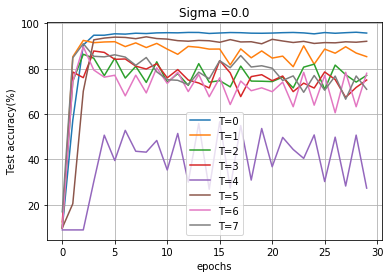

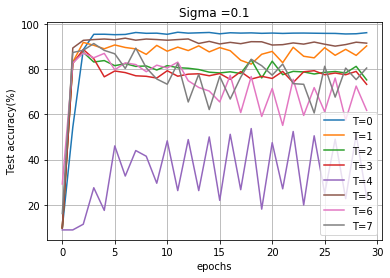

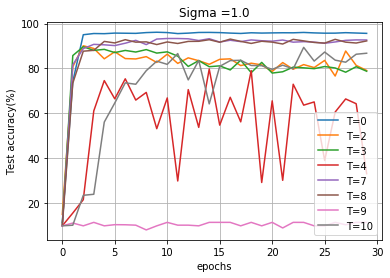

In [60]:
plot_acc_v2 = np.mean(acc_test_arr_v2, axis=2)
# print(acc_test_arr.shape)
print(plot_acc_v2.shape)

sigma_sel = 0

title_name = 'Sigma ='+str(sigma_array[sigma_sel])
plt.plot(plot_acc[0,sigma_sel,:],label='T=0')
plt.plot(plot_acc[1,sigma_sel,:],label='T=1')
plt.plot(plot_acc[2,sigma_sel,:],label='T=2')
plt.plot(plot_acc[3,sigma_sel,:],label='T=3')
plt.plot(plot_acc_v2[0,sigma_sel,:],label='T=4')
plt.plot(plot_acc_v2[1,sigma_sel,:],label='T=5')
plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=6')
plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=7')
# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

sigma_sel = 1

title_name = 'Sigma ='+str(sigma_array[sigma_sel])
plt.plot(plot_acc[0,sigma_sel,:],label='T=0')
plt.plot(plot_acc[1,sigma_sel,:],label='T=1')
plt.plot(plot_acc[2,sigma_sel,:],label='T=2')
plt.plot(plot_acc[3,sigma_sel,:],label='T=3')
plt.plot(plot_acc_v2[0,sigma_sel,:],label='T=4')
plt.plot(plot_acc_v2[1,sigma_sel,:],label='T=5')
plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=6')
plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=7')
# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

sigma_sel = 2

title_name = 'Sigma ='+str(sigma_array[sigma_sel])
plt.plot(plot_acc[0,sigma_sel,:],label='T=0')
# plt.plot(plot_acc[1,sigma_sel,:],label='T=1')
plt.plot(plot_acc[2,sigma_sel,:],label='T=2')
plt.plot(plot_acc[3,sigma_sel,:],label='T=3')
plt.plot(plot_acc_v2[0,sigma_sel,:],label='T=4')
# plt.plot(plot_acc_v2[1,sigma_sel,:],label='T=5')
# plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=6')
plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=7')
plt.plot(plot_acc_v2[4,sigma_sel,:],label='T=8')
plt.plot(plot_acc_v2[5,sigma_sel,:],label='T=9')
plt.plot(plot_acc_v2[6,sigma_sel,:],label='T=10')
# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

In [63]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N = args.num_users
K = args.num_partition




# training



N_trials = 1
N_epochs = 30

# m_array = np.array(range(4,16)) # m is the number of received result @ master
alloc_Num = 7
sigma_array = np.array([1])


loss_test_arr_v3 = np.empty((alloc_Num,len(sigma_array),N_trials,N_epochs))
acc_test_arr_v3  = np.empty((alloc_Num,len(sigma_array),N_trials,N_epochs))

for alloc_idx in range(alloc_Num):
    


    
    T = 4
    
    if alloc_idx == 0:
        Noise_Alloc = [0,1,2,3]
    elif alloc_idx == 1:
        Noise_Alloc = [0,2,4,6]
    elif alloc_idx == 2:
        Noise_Alloc = [1,3,5,7]
    elif alloc_idx == 3:
        Noise_Alloc = [0,3,6,9]
    elif alloc_idx == 4:
        Noise_Alloc = [6,7,8,9]
    elif alloc_idx == 5:
        Noise_Alloc = [1,3,5,8]
    else:
        Noise_Alloc = [1,3,6,8]
    Signal_Alloc = []
    for i in range(K+T):
        if i not in Noise_Alloc:
            Signal_Alloc.append(i)

    j_array = np.array(range(K+T))
    # print("j: ",(2*j_array+1)*math.pi/2/K,'\n')

    alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))

    i_array = np.array(range(N))
    z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
    
    for sigma_idx in range(len(sigma_array)):
        
        sigma = sigma_array[sigma_idx]

        X_tilde,a,b = BACC_Enc_withNoise(encoding_input_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_withNoise(encoding_label_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist2(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_v3[T_idx][sigma_idx][trial_idx][iter] = acc_test
                loss_test_arr_v3[T_idx][sigma_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

@BACC_Enc: N,K,T, m_i= 15 6 4 10000 

@BACC_Enc: N,K, m_i= 15 10 10000 

@BACC_Enc: N,K,T, m_i= 15 6 4 10000 

@BACC_Enc: N,K, m_i= 15 10 10000 

(T, sigma)= 4 1 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3021 
Accuracy: 1137/10000 (11.37%)

Round   0, Average loss 2.302 Test accuracy 11.370
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.2502 
Accuracy: 7330/10000 (73.30%)

Round   1, Average loss 2.250 Test accuracy 73.300
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.4723 
Accuracy: 8847/10000 (88.47%)

Round   2, Average loss 0.472 Test accuracy 88.470
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.3491 
Accuracy: 8881/10000 (88.81%)

Round   3, Average loss 0.349 Test accuracy 88.810
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2998 
Accuracy: 910


Test set: Average loss: 0.3334 
Accuracy: 9098/10000 (90.98%)

Round  14, Average loss 0.333 Test accuracy 90.980
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.3331 
Accuracy: 9032/10000 (90.32%)

Round  15, Average loss 0.333 Test accuracy 90.320
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2635 
Accuracy: 9240/10000 (92.40%)

Round  16, Average loss 0.264 Test accuracy 92.400
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2831 
Accuracy: 9219/10000 (92.19%)

Round  17, Average loss 0.283 Test accuracy 92.190
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.3069 
Accuracy: 9239/10000 (92.39%)

Round  18, Average loss 0.307 Test accuracy 92.390
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.3468 
Accuracy: 9111/10000 (91.11%)

Round  19, Average loss 0.347 Test accuracy 91

@BACC_Enc: N,K, m_i= 15 10 10000 

@BACC_Enc: N,K,T, m_i= 15 6 4 10000 

@BACC_Enc: N,K, m_i= 15 10 10000 

(T, sigma)= 4 1 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.5814 
Accuracy: 7609/10000 (76.09%)

Round   1, Average loss 1.581 Test accuracy 76.090
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.9816 
Accuracy: 8930/10000 (89.30%)

Round   2, Average loss 0.982 Test accuracy 89.300
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.7049 
Accuracy: 9046/10000 (90.46%)

Round   3, Average loss 1.705 Test accuracy 90.460
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.2611 
Accuracy: 8945/10000 (89.45%)

Round   4, Average loss


Test set: Average loss: 0.4610 
Accuracy: 8820/10000 (88.20%)

Round  14, Average loss 0.461 Test accuracy 88.200
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.3590 
Accuracy: 8978/10000 (89.78%)

Round  15, Average loss 0.359 Test accuracy 89.780
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.3794 
Accuracy: 8978/10000 (89.78%)

Round  16, Average loss 0.379 Test accuracy 89.780
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.4052 
Accuracy: 8903/10000 (89.03%)

Round  17, Average loss 0.405 Test accuracy 89.030
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.4834 
Accuracy: 8947/10000 (89.47%)

Round  18, Average loss 0.483 Test accuracy 89.470
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.4386 
Accuracy: 8669/10000 (86.69%)

Round  19, Average loss 0.439 Test accuracy 86

@BACC_Enc: N,K, m_i= 15 10 10000 

@BACC_Enc: N,K,T, m_i= 15 6 4 10000 

@BACC_Enc: N,K, m_i= 15 10 10000 

(T, sigma)= 4 1 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3011 
Accuracy: 1418/10000 (14.18%)

Round   0, Average loss 2.301 Test accuracy 14.180
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 3.0605 
Accuracy: 1028/10000 (10.28%)

Round   1, Average loss 3.060 Test accuracy 10.280
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.8841 
Accuracy: 3592/10000 (35.92%)

Round   2, Average loss 1.884 Test accuracy 35.920
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.5169 
Accuracy: 5141/10000 (51.41%)

Round   3, Average loss 1.517 Test accuracy 51.410
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.4262 
Accuracy: 6409/10000 (64.09%)

Round   4, Average l

(7, 1, 1, 30)


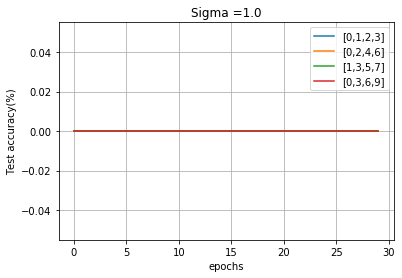

In [68]:
sigma_sel = 0

plot_acc_v3 = acc_test_arr_v3

print(plot_acc_v3.shape)

# if alloc_idx == 0:
#     Noise_Alloc = [0,1,2,3]
# elif alloc_idx == 1:
#     Noise_Alloc = [0,2,4,6]
# elif alloc_idx == 2:
#     Noise_Alloc = [1,3,5,7]
# elif alloc_idx == 3:
#     Noise_Alloc = [0,3,6,9]
# elif alloc_idx == 4:
#     Noise_Alloc = [6,7,8,9]
# elif alloc_idx == 5:
#     Noise_Alloc = [1,3,5,8]
# else:
#     Noise_Alloc = [1,3,6,8]

plt.plot(plot_acc_v3[0,sigma_sel,0,:],label='[0,1,2,3]')
plt.plot(plot_acc_v3[1,sigma_sel,0,:],label='[0,2,4,6]')
plt.plot(plot_acc_v3[2,sigma_sel,0,:],label='[1,3,5,7]')
plt.plot(plot_acc_v3[3,sigma_sel,0,:],label='[0,3,6,9]')
# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

In [71]:
print(acc_test_arr_v3[0,0,0,:])

[1.e-323 0.e+000 0.e+000 0.e+000 0.e+000 0.e+000 0.e+000 0.e+000 0.e+000
 0.e+000 0.e+000 0.e+000 0.e+000 0.e+000 0.e+000 0.e+000 0.e+000 0.e+000
 0.e+000 0.e+000 0.e+000 0.e+000 0.e+000 0.e+000 0.e+000 0.e+000 0.e+000
 0.e+000 0.e+000 0.e+000]


In [ ]:
()